In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,10

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


This notebook will be used to help characterize the ring oscillator that we may end up using for the current proposed ADC (an AD-TDC).

The first test we want to perform is to see how long each inverter stage takes to change.  In the Watanabe paper, this is the equivalent of $T_D$

In [2]:
# This script will parse a CSV file taken from the Spectre Simulations and extract out the Early Voltage
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv

#Global Functions and Variables

In [77]:
sampleTime = 20e-6

folderRoot="/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/"

def readFile(folderRoot, fileName):
    with open(folderRoot+fileName) as fn:
        reader = csv.reader(fn)
        sampleTimes = list()
        for i, row in enumerate(reader):
            if i>1:
                sampleTimes.append(array(sorted(map(double,row[1::]))))
    return sampleTimes

def readFileUnsorted(folderRoot, fileName):
    with open(folderRoot+fileName) as fn:
        reader = csv.reader(fn)
        sampleTimes = list()
        for i, row in enumerate(reader):
            if i>1:
                sampleTimes.append(array(map(double,row[1::])))
    return sampleTimes

# This is the method to use for reading the measurements if the measurements that you want are 
# the last element of any row.
def readFile2(folderRoot, fileName):
    with open(folderRoot+fileName) as fn:
        reader = csv.reader(fn)
        freqs = list()
        for i, row in enumerate(reader):
            # Save a filtered form of the first row so that the second row can be compared to it.
            if i == 1:
                prevRow = filter(lambda x: x!='  ',row)
                #print prevRow
            if i>1:
                # Compare the length of the previous row vs the filtered current row
                # The filtering just checks that any double spaces are removed from the list
                # If the length of the rows differs, take the last value and add it to the list of freqs.
                if len(prevRow)!=len(filter(lambda x: x!='  ',row)):
                    #print len(prevRow), prevRow
                    #print len(filter(lambda x: x!='  ',row)), row
                    freqs.append(double(prevRow[-1]))
                # Save the filtered form of the current list as the previous row for the next iteration.
                prevRow = filter(lambda x: x!='  ',row)
        # Save the last row's freq as the last data point
        freqs.append(double(filter(lambda x: x!= '  ',row)[-1]))
    return list(reversed(freqs))

# This is the readFile to use if any given row is an accurate sample of the frequencies.
# In this instance, I'll take the last row to be the data point that I care about.
def readFile3(folderRoot, fileName):
    with open(folderRoot+fileName) as fn:
        reader = csv.reader(fn)
        sampleTimes = list()
        for i, row in enumerate(reader):
            if i>=1:
                sampleTimes.append(array(sorted(map(double,row[1::2]))))
    return sampleTimes[-1]

def plotFreqs(Xs, Ys, temp, pltRange, plotLog=False):
    rangeX, rangeY = pltRange[0], pltRange[1]    
    lenYs = len(Ys)
    if plotLog:
        loglog(Xs[:lenYs],Ys, '.-',label=str(temp)+"C")
    else:
        plot(Xs[:lenYs],Ys, '.-',label=str(temp)+"C")
    xlabel('$I_{in}$')
    ylabel('Freq (Hz)')
    title('Ring Oscillator Frequency vs $I_{in}$')
    xlim([0,rangeX])
    ylim([0,rangeY])

def plotGen(Xs, Ys, temp, pltRange, plotType='.-', plotLog=False, ttl='Default Title', xlbl='xLabel', ylbl='yLabel'):
    rangeX, rangeY = pltRange[0], pltRange[1]    
    lenYs = len(Ys)
    if plotLog:
        loglog(Xs[:lenYs],Ys, plotType, label=str(temp)+"C")
    else:
        plot(Xs[:lenYs],Ys, plotType, label=str(temp)+"C")
    xlabel(xlbl)
    ylabel(ylbl)
    title(ttl)
    xlim(rangeX)
    ylim(rangeY)

In [8]:
def linfit(xdata, params):
    m, b, I0 = params
    return m/(xdata-I0) + b

def linfitErr(params, xdata, ydata):
    m, b, I0 = params
    
    return ydata - (m/(xdata-I0) + b)
    #return ydata - linfit(xdata, params)

In [82]:
def plotLinearityT(invIins, AH_Ts, curTemp, x_th, Ts_th):
    subplot(2,2,1)
    # Plot on a linear scale
    plotGen(invIins,AH_Ts, curTemp, [[0,max(invIins)], [0,max(AH_Ts)]],
    #plotGen(invIins,delayInv_Ts, curTemp, [[0,10],[0,10]],
            plotType = '.',
            ttl='Ring Oscillator Period',
            xlbl='$\\frac{1}{I_{in}} (\\frac{1}{A})$',
            ylbl='$T(\mu s)$')
    plot(1./x_th, Ts_th)

    subplot(2,2,2)
    # Plot the derivative
    derivTs = diff(AH_Ts)/diff(invIins)
    plotGen(invIins[1:], derivTs, curTemp, [[0,max(invIins[1:])],[min(derivTs),max(derivTs)]],
            plotType='-',
            ttl='Derivative of Ring Oscillator Period',
            xlbl='$\\frac{1}{I_{in}} (\\frac{1}{A})$',
            ylbl='$\\frac{dT}{d\\frac{1}{I_{in}}}$')

def plotLinearityF(Iins, AH_Freqs, curTemp):
    subplot(2,2,3)
    plotGen(Iins,AH_Freqs, curTemp, [[0,max(Iins)], [0,max(AH_Freqs)]],
    #plotGen(invIins,delayInv_Ts, curTemp, [[0,10],[0,10]],
            plotType = '.',
            ttl='Ring Oscillator Freq',
            xlbl='$\\frac{1}{I_{in}} (\\frac{1}{A})$',
            ylbl='$F(Hz)$')
    
    subplot(2,2,4)
    derivFs = diff(AH_Freqs)/diff(Iins)
    plotGen(Iins[1:], derivFs, curTemp, [[0,max(Iins[1:])],[min(derivFs),max(derivFs)]],
            plotType='-',
            ttl='Derivative of Ring Oscillator Freq',
            xlbl='$I_{in} (A)$',
            ylbl='$\\frac{dF}{dI_{in}}$')

def plotLinearity(fileName):
    #AH_Freqs = array(readFile2(folderRoot, fileName))
    AH_Freqs = array(readFile3(folderRoot, fileName))
    AH_Ts = (1./AH_Freqs)*1e6
    allTs.append(AH_Ts)
    #print delayInv_Ts
    #print invIins
    x_th = linspace(min(scaledIins),max(scaledIins), num=100)
    sol = leastsq(linfitErr, (1.1, 0.001, 0), (scaledIins, AH_Ts))
    print sol[0]
    Ts_th = linfit(x_th, sol[0])

    plotLinearityT(invIins, AH_Ts, curTemp, x_th, Ts_th)
    #plotLinearityF(Iins, AH_Freqs, curTemp)

#Axon Hillock (AH) Analysis

##Linearity Analysis

This section will have all of the linearity analysis that I will perform for the AH circuit.  The goal will be to see if we can figure out if this circuit is truly nonlinear like we want, and if not, where the nonlinearity is coming from.

This just gets the value of the swept parameters, $I_{in}$ and Temp (if the temperature was swept)

In [47]:
paramFile = open(folderRoot+"SweptParams.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i == 0:
        temps = array(row[1:])
        print "Temps: ", temps
    elif i==1:
        Iins = array(double(row[1:]))
        print "Iins: ", Iins
    else:
        print "Too many rows"
scaledIins = Iins*1e9
invIins = 1./scaledIins

Temps:  ['0' '5' '10' '15' '20' '25' '30' '35' '40' '45' '50']
Iins:  [  1.00000000e-11   2.15443469e-11   4.64158883e-11   1.00000000e-10
   2.15443469e-10   4.64158883e-10   1.00000000e-09   2.15443469e-09
   4.64158883e-09   1.00000000e-08]


The circuit below is my first stab at an AH implementation.  This implementation uses only Thick Oxide (eg) transistors in the circuit, including for the MOSCap.  The configuration used for this includes a starved inverter that feeds into the capacitance divider, which then feeds into two consecutive inverters (to act as a gain amplifier/buffer).  The output of this buffer is then fed back into one of the terminals of C2 (the top capacitor of the capacitance divider).

The be more specific about the description, the starved inverter has 4 transistors in series (the drain of one transistor connects to the drain of the next transistor).  The top transistor's -- a PFET sized as 2 transistors, 180n x 150n, 3L -- gate is controlled by $V_{gp}$, which is set to the value corresponding to $I_{in}$ through a PFET transistor.  The next two transistors, a PFET on top of an NFET, form a generic inverter (same width and length as the transistors above, but only 1L) whose gate is controlled by the "out" node.  The purpose of this inverter is to switch between the top current source and the bottom current source.  The bottom current source is implemented by an NFET transistor -- sized as 2 transistors wide, 160n x 150n, 3L -- with its gate connected $V_{gn}$.  $V_{gn}$ is set by a current mirror through and NFET.  In the case of both $V_{gp}$ and $V_{gn}$, the gate voltages are actually buffered using a vcvs with a gain of 1, so that we can try to best eliminate other transient effects from our current understanding.

All subsequent designs/analysis branch from this basic design in order to best find out where the nonlinearity is coming from, b/c as we can see below, this basic design is still nonlinear.

[  5.65319629e-01   1.18416036e-01  -2.11214771e-04]


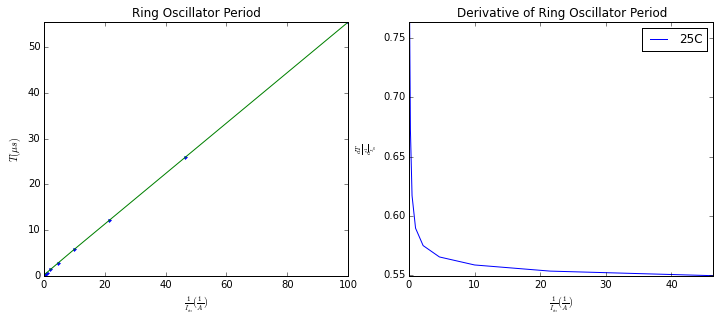

In [48]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C.csv"
    plotLinearity(fileName)

    legend(loc='best')

###No Buffer
This first deviation is the analysis if we take the buffers out of the picture and have the throttling transistors (the top (PFET) and bottom (NFET) transistors) being controlled directly by the current mirror.  Otherwise, everything in this setup is same as before.

[  4.77683369e-01   1.20327169e-01  -2.28120678e-04]


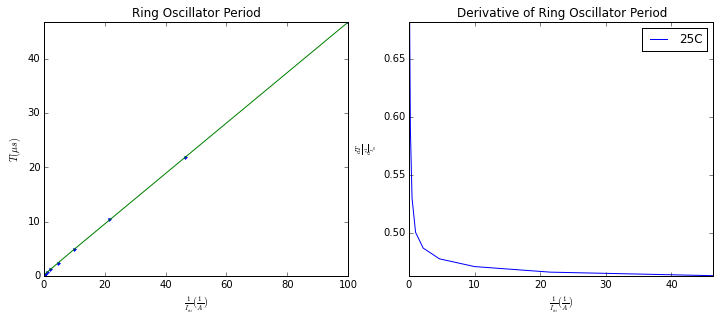

In [65]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer.csv"
    plotLinearity(fileName)
legend(loc='best')

###Sizing the Capacitors
In this section, I try to ween out whether or not the size of the capacitors affects the linearity.  I thought they might be affecting the linearity because they might have been operating in a region where the the CV curve isn't flat, and therefore, the capacitance value was changing.  As such, I thought if I could get the $\Delta V$ value of $V_{cap}$ to swing by less, then the capacitor would operate in a similar regime always and would therefore, be more likely to be linear.  $\Delta V$ should swing by an amount equal to $\frac{C_2}{C_1+C_2}$, and therefore, my first idea was to increase $C_1$'s capacitance.

It should be noted that I also tried to characterize the capacitors a little bit, and following my characterization as well as Ben's CV curves, I chose to use an NFET that's minimum sized, with it's Source and Drain nodes connected to $V_{cap}$.  When the S and D nodes are connected to the $V_{cap}$ node, it was shown that this helped with the linearity of the capacitor the most, and that is why this configuration was chosen.  Assuming Ben's analysis and my analysis are similar, I'm using the working approximation of $C_1$ and $C_2$ to be $\approx150aA$.

It should also be noted that for all of these cap-sizing analyses, there was no buffer between the current mirror and the throttling gates.  This was because a quick analysis showed that they didn't change the behavior by much.  My intuition for why this is the case is because there aren't enough mirrored gates which have their own capacitance to weigh down the line to cause any unexpected behavior.

####  $C_1$ 460n X 450n 1L 
The easiest way to increase capacitance is to increase the area of the "plates" and as such, I made $C_1$ roughly 3 times wider and 3 times longer.  As you can see it doesn't really change the linearity of the plot.

[  4.79256018e-01   1.29532442e-01  -2.40480673e-04]


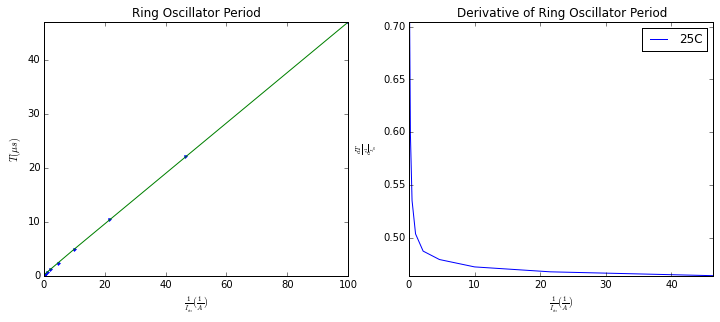

In [66]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C1_460nx450n1L.csv"
    plotLinearity(fileName)
legend(loc='best')

####  $C_1$ 460n X 450n 3L 
The next thing I tried was to make the transistor even longer.

[  4.79481350e-01   1.29620503e-01  -2.44500782e-04]


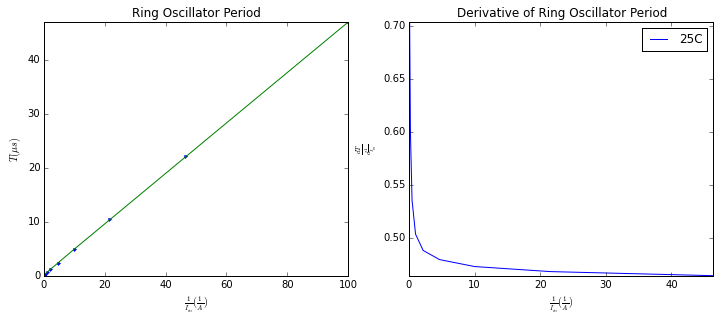

In [67]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C1_460nx450n3L.csv"
    plotLinearity(fileName)
legend(loc='best')

####  $C_1$ 160n X 150n 3L 
Just to check what is going on, I reverted back to the original dimensions of the transistors, but kept the 3 transistors-in-series-design for the capacitance.  I didn't expect this circuit to be linear, and sure enough it wasn't.

[  4.78157270e-01   1.19265569e-01  -2.38668777e-04]


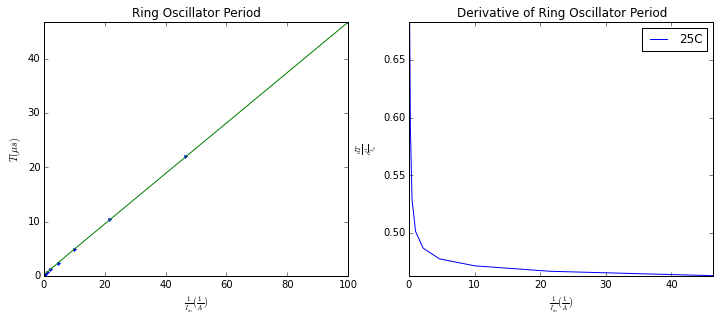

In [52]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C1_160nx150n3L.csv"
    plotLinearity(fileName)
legend(loc='best')

####  $C_2$ 460n X 450n 1L 
Just to double check my intuition, I wanted to test what would happen if I sized $C_2$ with a larger capacitance.  The first thing that it should have done is make the circuit slower, which it does, as evidenced from the overall length of the period.  It should make the circuit slower because now $\Delta V$ should jump by a larger proportion of $V_{dd}$, which means the capacitance has a farther way to travel to get back to the transition point of the inverter.

The second thing my intuition said it should not do is change the linearity.  Sure enough, the circuit is still nonlinear by roughly the same degree as the previous implementations.

[  7.59935950e-01   1.43551166e-01  -2.07416919e-04]


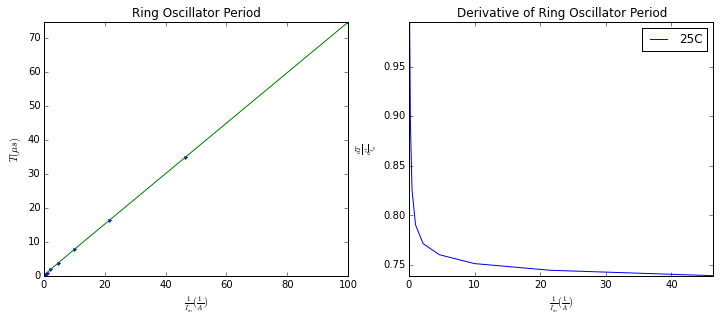

In [54]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C2_460nx450n1L.csv"
    plotLinearity(fileName)
legend(loc='best')

####  $C_2$ 460n X 450n 3L 
Just to cover my bases, I tried this final configuration.  Interestingly, this was the first analysis where the slope wasn't monotonic.  I'm not sure why this is the case, but decided after this that I should try to better understand where the nonlinearity is coming from by using ideal elements instead of transistors which have their own underlying behaviors complicating my understand of what is happening.

[  8.31310299e-01   8.65510529e-02   3.64851906e-04]


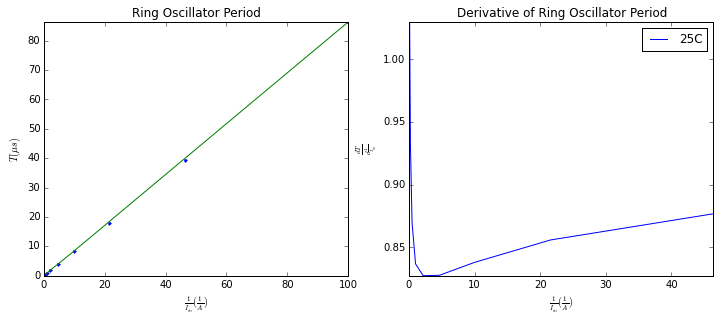

In [56]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C2_460nx450n3L.csv"
    plotLinearity(fileName)
legend(loc='best')

###  Ideal Caps for $C_1$ and $C_2$ 
In this section, I make the assumption that the capacitors are behaving linearly because my cap sizing experiments didn't show any greatly different effects between the many configurations.  To test this assumption, I use ideal capacitors in the simulation and then try to vet out what what actually causes any of the nonlinearity.

This first measurement shows two things.  First it shows that using an approximate value of 150aA, is on the same order as the previous measurements, because the circuit has a similar period over the same range of input currents.  The second thing it shows is that even using ideal capacitors, the circuit is still behaving nonlinearly.  This confirms my hypothesis that some other part of the circuit is causing the nonlinearity.

[  5.63447587e-01   1.24121549e-01  -2.22920361e-04]


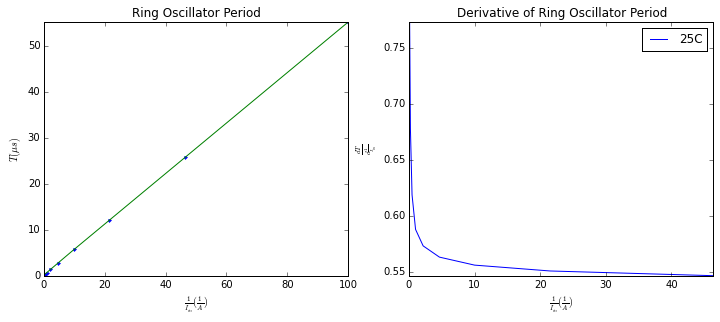

In [57]:
llTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_IdealCaps_150a.csv"
    plotLinearity(fileName)
legend(loc='best')

####Switch on the Rails
My first theory regarding where the nonlinearity might be coming from is that I am using two transistors to try and control which current source is charging or discharging the capacitors.  In the original configuration these switching transitors were placed at the drains of my throttling transistors (or current sources).  In this test, I move the switches to the rails so that they are placed at the sources of the current sources.  I double checked that when I do this, the node between the switch and the current source goes all the way up to 1V and down to 0V, respectively, so that we can ensure that the current mirror operates properly.  To also ensure that this current mirror operates properly, I have reverted back to using a buffer on the gates of these throttling transistors.  It allows me to ensure that I am worrying about one less possible source of nonlinearity.

Sadly, this doesn't help the circuit much and it still behaves nonlinearly.

[  5.88111563e-01   1.40397589e-01  -2.66061953e-04]


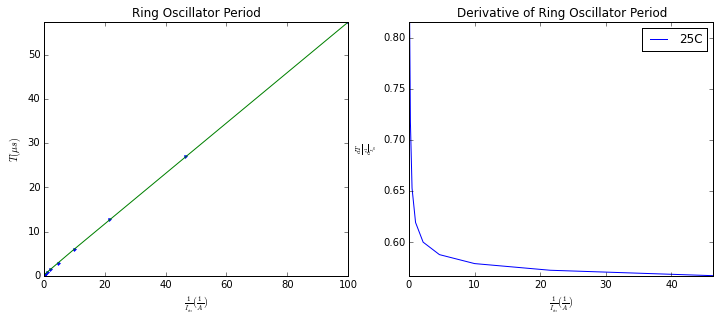

In [60]:
llTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_Buffer_SwitchonEdges_IdealCaps_150a.csv"
    plotLinearity(fileName)
legend(loc='best')

####  Ideal Current Sources
My next guess was that using transistors for the gates might be causing some nonlinearity, and as such, I should just try ideal current sources.  This will prove whether the nonlinearity is coming from the inverters or not.  It eliminates the throttling transistors as a source of the nonlinearity for now.  This is not to say they aren't contributing to the nonlinearity, but if the circuit is still nonlinear after this, then it must be coming from the inverters because every other part of this circuit is using an ideal component now.

Sure enough this circuit is nonlinear and as such, the nonlinearity must be coming from the two inverters that are used to form a buffer.

[  2.90781136e-01   8.44949409e-02  -2.11868711e-04]


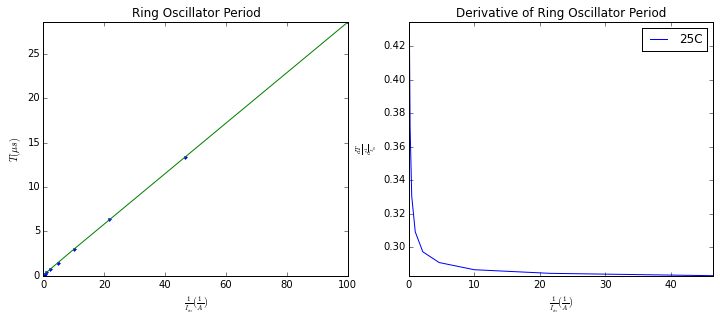

In [62]:
llTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_IdealCS_IdealCaps_150a.csv"
    plotLinearity(fileName)
legend(loc='best')

####  Ideal AH circuit
Because we think the nonlinearity is coming from the inverters, we want to see that an ideal circuit behaves linearly by using all ideal components.  This establishes that the circuit should theoretically work linearly.

Happily enough, this circuit operates very linearly, even in the frequency domain! :-D

Because this is the equivalent of having a "baseline" measurement, I also plotted all of the temperatures to show how the ideal AH circuit should behave with variation in temperature.

[  2.99457808e-01  -9.77332121e-05   1.08780842e-06]
[  2.99444466e-01  -1.73280624e-05   1.72384888e-06]
[  2.99525753e-01  -2.61042389e-04  -1.53259257e-06]
[  2.99463948e-01  -6.23962205e-05   2.60486062e-07]
[  2.99384926e-01   1.70314062e-04   2.98429938e-06]
[  2.99452672e-01  -4.79948300e-05  -4.06799353e-07]
[  2.99453440e-01  -2.85422749e-05   7.62918100e-07]
[  2.99417086e-01   1.30723298e-04   1.86086851e-06]
[  2.99482086e-01  -3.48348725e-05  -1.31942871e-06]
[  2.99527455e-01  -1.32177885e-04  -4.15301953e-06]
[  2.99464932e-01  -4.19398675e-05   1.05520903e-07]


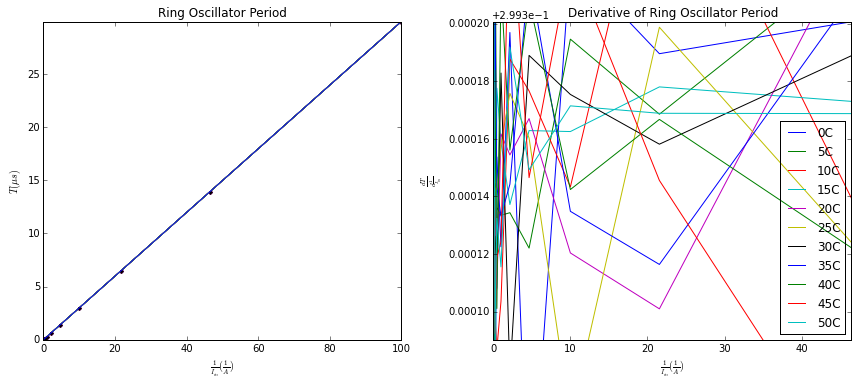

In [84]:
llTs = list(list())

for curTemp in temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_IdealAH.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

###Ideal Amplifier Buffer
####Ideal capacitors $C_1$ and $C_2$ and non-ideal switched current sources
In this test, I got rid of the ideal current sources, but kept the ideal caps and the ideal buffer.  This will hopefully result in a linear plot and thereby give more evidence that the nonlinearity is coming from the inverters that I use to create the buffer.

Assuming this is linear, then my next test will be to take the ideal caps and make them MOSCaps again (with minimum sizing for thick oxide.

As can be seen below, the starved inverter that acts as a switch source for the inverters introduces some nonlinearity, but the overall nonlinearity is still very small (a ratio of 1.04 (.855/.820) from one end of the range to the other).  This is promising and helps us further incriminate the amplifier buffer as the main source of the nonlinearity.

[  8.31837939e-01   2.65722853e-02  -1.22865719e-04]


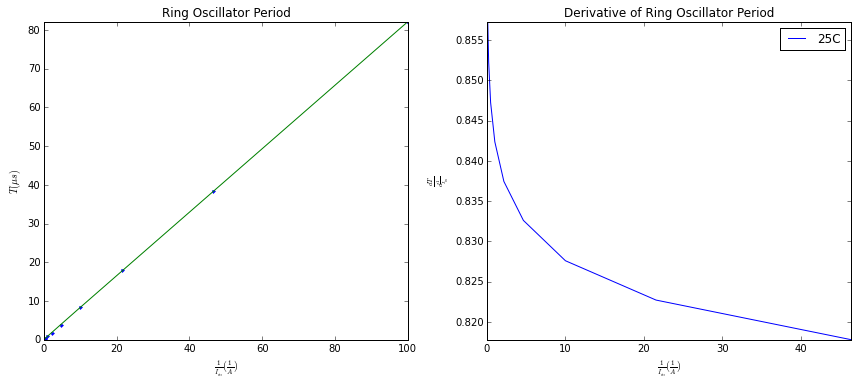

In [88]:
llTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_IdealAmplifierBuffer_IdealCaps.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

####Non-ideal capacitors and non-ideal switched current sources
The result below shows that although having non-ideal capacitors and non-ideal current sources still accounts for some of the nonlinearities, the bulk of the nonlinearity is because of the two inverters used to create a buffer in the axon-hillock circuit.  This is great because it shows us that we really need to focus on making the buffer nice and linear and then this circuit will work much better.

[  7.44801215e-01   2.41643517e-02  -1.26536515e-04]


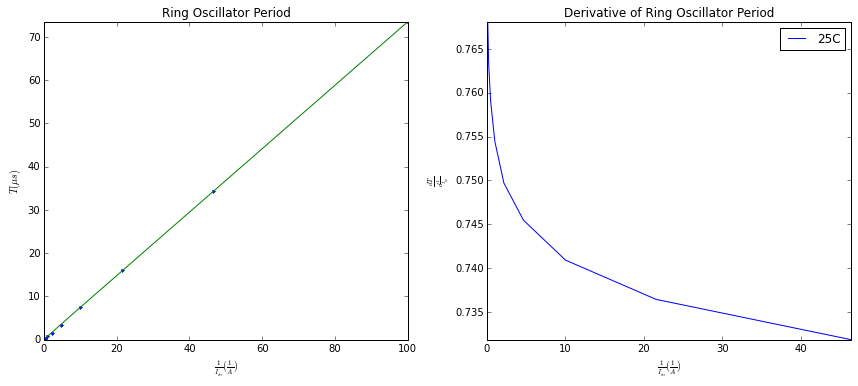

In [89]:
llTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_IdealAmplifierBuffer.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()